In [73]:
import os
import pandas as pd
import pickle
import numpy as np
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.linear_model import LogisticRegression as lr
from sklearn.svm import SVC as sv
#from sklearn.svm import LinearSVC as sv
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold as skf

from sklearn.model_selection import GridSearchCV

In [74]:
def calculate_diagnostic_performance(actual_predicted):
    """ Calculate sensitivty and specificty.
    Takes a Numpy array of 1 and zero, two columns: actual and predicted
    Returns a tuple of results:
    1) accuracy: proportion of test results that are correct    
    2) sensitivity: proportion of true +ve identified
    3) specificity: proportion of true -ve identified
    4) positive likelihood: increased probability of true +ve if test +ve
    5) negative likelihood: reduced probability of true +ve if test -ve
    6) false positive rate: proportion of false +ves in true -ve patients
    7) false negative rate:  proportion of false -ves in true +ve patients
    8) positive predictive value: chance of true +ve if test +ve
    9) negative predictive value: chance of true -ve if test -ve
    10) Count of test positives

    *false positive rate is the percentage of healthy individuals who 
    incorrectly receive a positive test result
    * alse neagtive rate is the percentage of diseased individuals who 
    incorrectly receive a negative test result
    
    """
    #actual_predicted = test_results.values
    actual_positives = actual_predicted[:, 0] == 1
    actual_negatives = actual_predicted[:, 0] == 0
    test_positives = actual_predicted[:, 1] == 1
    test_negatives = actual_predicted[:, 1] == 0
    test_correct = actual_predicted[:, 0] == actual_predicted[:, 1]
    accuracy = np.average(test_correct)
    true_positives = actual_positives & test_positives
    true_negatives = actual_negatives & test_negatives
    sensitivity = np.sum(true_positives) / np.sum(actual_positives)
    specificity = np.sum(true_negatives) / np.sum(actual_negatives)
    positive_likelihood = sensitivity / (1 - specificity)
    negative_likelihood = (1 - sensitivity) / specificity
    false_postive_rate = 1 - specificity
    false_negative_rate = 1 - sensitivity
    positive_predictive_value = np.sum(true_positives) / np.sum(test_positives)
    negative_predicitive_value = np.sum(true_negatives) / np.sum(test_negatives)
    positive_rate = np.mean(actual_predicted[:,1])
    return ['accuracy', 'sensitivity', 'specificity', 'positive_likelihood',
            'negative_likelihood', 'false_postive_rate', 'false_negative_rate',
            'positive_predictive_value', 'negative_predicitive_value',
            'positive_rate'], [accuracy, sensitivity, specificity, positive_likelihood,
            negative_likelihood, false_postive_rate, false_negative_rate,
            positive_predictive_value, negative_predicitive_value,
            positive_rate]

In [75]:
def bootstrap_metrics(y_true, y_pred, y_prob, n_iter):
    
    vals=[]
    for iteration in range(n_iter):
        selection = np.random.randint(0,len(y_true), size=3460)

        true = [y_true[i] for i in selection]
        pred = [y_pred[i] for i in selection]
        prob = [y_prob[i] for i in selection]
        
        ap = np.array(list(zip(true,pred)))
        _,performance = calculate_diagnostic_performance(ap)
        
        auc = roc_auc_score(true, prob)
        
        
        vals.append([performance[0],performance[1], performance[2], performance[-2], performance[-3], auc])
        
    return vals

## 2 years 

In [4]:
with open('processed_data.pkl', 'rb') as f:
    [data, variables, outcome] = pickle.load(f)

In [5]:
with open('ImpVars_dummy.pkl', 'rb') as f:
    [_,_,_,variables_old,_,var_types_old,_] = pickle.load(f)

In [6]:
# :-4 to discount random variables

var_types = [var_types_old[np.where(variables_old==v)[0][0]] for v in variables[:-4]]

In [7]:
var_types.extend(['Random','Continuous','Binary','Categorical'])

In [8]:
var_types[-1]

'Categorical'

In [9]:
set(var_types)

{'Binary', 'Categorical', 'Continuous', 'Discrete', 'Ordinal', 'Random'}

In [10]:
len(variables), len(variables_old)

(258, 260)

In [11]:
np.savetxt('variables.csv', np.array(variables).astype(str), fmt='%s',delimiter = ',')

In [76]:
def add_new_variable(name, n):
    
    new_vars = []
    
    for indx in range(n):
        
        new_vars.append('_'.join([name,str(indx)]))
        
        
    return new_vars

In [13]:
#variables

In [14]:
%%time

from sklearn import preprocessing
enc = preprocessing.OneHotEncoder()

#data = np.vstack((train_data, test_data))

count=0

for i,type_ in enumerate(var_types):
    
    if type_=='Categorical':
        
        print(variables[i-count])
        
        X = data[:,i-count].reshape(-1, 1)
        enc.fit(X)
        X_new = enc.transform(X).toarray()
        #print(X_new)
        
        data = np.delete(data, i-count, 1)
        data = np.hstack((data, X_new))
        
        new_vars = add_new_variable(variables[i-count], len(X_new[0]))
        
        variables = np.delete(variables, i-count)
        variables = np.concatenate((variables, new_vars))
        
        count+=1
        
data = preprocessing.scale(data)

NACCREAS
NACCREFR
HISPOR
PRIMLANG
NACCLIVS
RESIDENC
MARISTAT
HANDED
NACCNIHR
INRELTO
CVHATT
CVAFIB
CVANGIO
CVBYPASS
CVPACE
CVCHF
CVOTHR
CBSTROKE
CBTIA
SEIZURES
TRAUMBRF
TRAUMEXT
TRAUMCHR
NCOTHR
HYPERTEN
HYPERCHO
DIABETES
B12DEF
THYROID
INCONTU
INCONTF
ALCOHOL
ABUSOTHR
PSYCDIS
NPIQINF
NACCCOGF
COGMODE
NACCBEHF
BEMODE
NACCMOTF
MOMODE
COURSE
FRSTCHG
MMSELOC
MMSELAN
MMSEORDA_PROB
MMSEORLO_PROB
NACCMMSE_PROB
NPSYCLOC
NPSYLAN
LOGIMEM_PROB
DIGIF_PROB
DIGIFLEN_PROB
DIGIB_PROB
DIGIBLEN_PROB
ANIMALS_PROB
VEG_PROB
TRAILA_PROB
TRAILB_PROB
WAIS_PROB
MEMUNITS_PROB
BOSTON_PROB
COGSTAT
RANDVAR_3
CPU times: user 1.76 s, sys: 992 ms, total: 2.75 s
Wall time: 2.72 s


In [69]:
data.shape

(15307, 443)

In [71]:
np.save('encoded_data.npy', data)

In [72]:
np.save('outcome.npy', np.array(outcome, dtype=int) )

### K-fold cv 

In [22]:
def run_k_fold(model,name,params,data,outcome):

    sk = skf(n_splits=5)

    auc, metrics, models, err, feat, probs, preds = [],[],[],[],[],[],[]

    outcome = np.array(outcome, dtype=int)

    for train, test in sk.split(data, outcome):

        clf = GridSearchCV(model, params, n_jobs = -1)

        clf.fit(data[train], outcome[train])

        

        best = clf.best_estimator_
        
        models.append(best)

        pred = best.predict(data[test])
        prob = best.predict_proba(data[test])[:,1]

        auc.append(roc_auc_score(outcome[test], prob))

        ap = np.array(list(zip(outcome[test],pred)))

        _, performance = calculate_diagnostic_performance(ap)

        metrics.append(performance)

        errors = bootstrap_metrics(outcome[test], pred, prob,1000)

        err.append(errors)
        
        probs.extend(prob)
        
        preds.extend(pred)
        
        
        print(name)
        
        if name in ['RF','XGB']:

            feat.append(best.feature_importances_)
            
        else:
            
            feat.append(best.coef_[0]) 
            
    return auc, metrics, models, err, feat, probs, preds 

#### RF 

In [23]:
%%time

params = {'n_estimators':[50,100,200],
             'criterion': ('gini', 'entropy'),
             'min_samples_split': [2,10,20],
             'max_depth': [10,50],
             'max_features': (20, 50)
             }

model = rf()

rf_auc, rf_metrics, rf_models, rf_err, rf_feat, rf_probs, rf_preds = run_k_fold(model,'RF',params,data,outcome)

RF
RF
RF
RF
RF
CPU times: user 1min 24s, sys: 1.41 s, total: 1min 25s
Wall time: 5min 40s


In [24]:
np.mean(rf_metrics, axis=0)

array([9.15724616e-01, 3.17596305e-01, 9.83987030e-01, 2.01017246e+01,
       6.93497766e-01, 1.60129696e-02, 6.82403695e-01, 6.94532686e-01,
       9.26660288e-01, 4.69069269e-02])

In [26]:
with open ('5fold/rf_results.pkl', 'wb') as f:
    
    pickle.dump([rf_auc, rf_metrics, rf_models, rf_err, rf_feat, rf_probs, rf_preds, variables], f)

#### LR

In [27]:
lr_params={'C':[0.1,1,5,10],
          'max_iter':[10000]}


model = lr()

lr_auc, lr_metrics, lr_models, lr_err, lr_feat, lr_probs, lr_preds = run_k_fold(model,'LR',lr_params,data,outcome)

LR
LR
LR
LR
LR


In [28]:
with open ('5fold/lr_results.pkl', 'wb') as f:
    
    pickle.dump([lr_auc, lr_metrics, lr_models, lr_err, lr_feat, lr_probs, lr_preds, variables], f)

#### SVM

In [29]:
%%time

svm_params={'C':[0.1,1,10]}

model = sv(probability=True, kernel = 'linear')

sv_auc, sv_metrics, sv_models, sv_err, sv_feat, sv_probs, sv_preds = run_k_fold(model,'SVM',svm_params,data,outcome)

SVM
SVM
SVM
SVM
SVM
CPU times: user 24min 1s, sys: 19.5 s, total: 24min 20s
Wall time: 4h 43min 39s


In [30]:
with open ('5fold/svm_results.pkl', 'wb') as f:
    
    pickle.dump([sv_auc, sv_metrics, sv_models, sv_err, sv_feat, sv_probs, sv_preds, variables], f)

#### XGB

In [33]:
params = {'n_estimators':[50,100,200],
             'criterion': ('friedman_mse', 'mse', 'mae'),
             'min_samples_split': [2,5,10,20],
             'max_depth': [5,10,50],
             'max_features': ('sqrt', 'log2', 20, 50)
             }

model = GradientBoostingClassifier(random_state=0)

xg_auc, xg_metrics, xg_models, xg_err, xg_feat, xg_probs, xg_preds = run_k_fold(model,'XGB',params,data,outcome)

XGB
XGB
XGB
XGB
XGB


In [34]:
with open ('5fold/xgb_results.pkl', 'wb') as f:
    
    pickle.dump([xg_auc, xg_metrics, xg_models, xg_err, xg_feat, xg_probs, xg_preds, variables], f)

## AUC vs features

In [35]:
from sklearn.metrics import auc

def bootstrap_auc(probability, classes, n_iter):
    
    auc_vals=[]
    for iteration in range(n_iter):
        selection = np.random.randint(0,len(classes), size=1000)

        probs = [probability[i] for i in selection]
        class_ = [classes[i] for i in selection]
        
        
        auc_vals.append(roc_auc_score(class_, probs))
        
    return np.percentile(auc_vals, 25), np.percentile(auc_vals,75), np.median(auc_vals)

In [65]:
def auc_feat(models, feat, data, outcome):
    
    idx = np.array(list(range(len(feat))))
    
    idx = [x for _, x in sorted(zip(feat,idx), key=lambda pair: pair[0], reverse=True)]
    feat = [y for y, _ in sorted(zip(feat,idx), key=lambda pair: pair[0], reverse=True)]
    
    sk = skf(n_splits=5)

    #auc, metrics, models, err, feat, probs, preds = [],[],[],[],[],[],[]

    outcome = np.array(outcome, dtype=int)
    
        
    auc = []
    l,h,m = [],[],[]
    
    for i,index in enumerate(idx[:40]):
        
        print(f'{i+1} features')
        
        count = 0
        
        probs, preds, true = [],[],[]

        for train, test in sk.split(data, outcome):

            features = idx[:(i+1)]
            
            X_train = np.array(data[train][:,features])

            X_test = np.array(data[test][:,features])

            clf = models[count]
            
            clf.set_params(max_features = i+1)
            
            clf.fit(X_train, outcome[train])
            _, y_prob = zip(*clf.predict_proba(X_test))
            
            probs.extend(y_prob)
            true.extend(outcome[test])
            
            count+=1

        auc.append(roc_auc_score(true, probs))

        low,high,med = bootstrap_auc(probs,true, 1000)

        l.append(low)
        h.append(high)
        m.append(med)
        
    return auc, l, m, h

### RF 

In [53]:
%%time

auc, l, m, h =  auc_feat(rf_models, np.mean(rf_feat, axis=0), data, outcome)

1 features
2 features
3 features
4 features
5 features
6 features
7 features
8 features
9 features
10 features
11 features
12 features
13 features
14 features
15 features
16 features
17 features
18 features
19 features
20 features
21 features
22 features
23 features
24 features
25 features
26 features
27 features
28 features
29 features
30 features
31 features
32 features
33 features
34 features
35 features
36 features
37 features
38 features
39 features
40 features
CPU times: user 36min 6s, sys: 1.75 s, total: 36min 7s
Wall time: 36min 7s


In [54]:
np.save('./5fold/rf_auc_low_hi_med.npy',[auc, l, m, h])

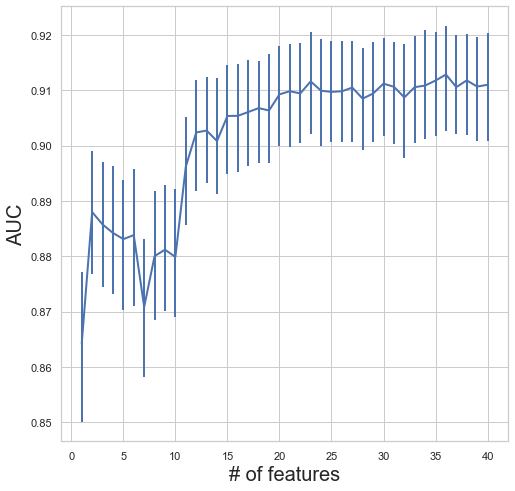

In [56]:
import seaborn as sns
sns.set(style="whitegrid")


x = list(range(1,41))

fig,ax = plt.subplots(figsize=(8,8))
plt.errorbar(x,m, yerr = np.vstack((np.array(m)-np.array(l),np.array(h)-np.array(m))), alpha=1, linewidth=2)
#plt.plot(x,auc_vals, 'r-o', ms=5)
plt.xlabel('# of features', fontsize=20)
plt.ylabel('AUC', fontsize=20)
#plt.savefig('auc_v_features_rf_2yr_new.pdf')
plt.show()

### Logistic Regression

In [59]:
%%time

auc, l, m, h =  auc_feat(lr_models, np.mean(lr_feat, axis=0), data, outcome)

1 features
2 features
3 features
4 features
5 features
6 features
7 features
8 features
9 features
10 features
11 features
12 features
13 features
14 features
15 features
16 features
17 features
18 features
19 features
20 features
21 features
22 features
23 features
24 features
25 features
26 features
27 features
28 features
29 features
30 features
31 features
32 features
33 features
34 features
35 features
36 features
37 features
38 features
39 features
40 features
CPU times: user 5min 52s, sys: 13min 53s, total: 19min 45s
Wall time: 1min 58s


In [60]:
np.save('./lr_auc_low_hi_med.npy',[auc, l, m, h])

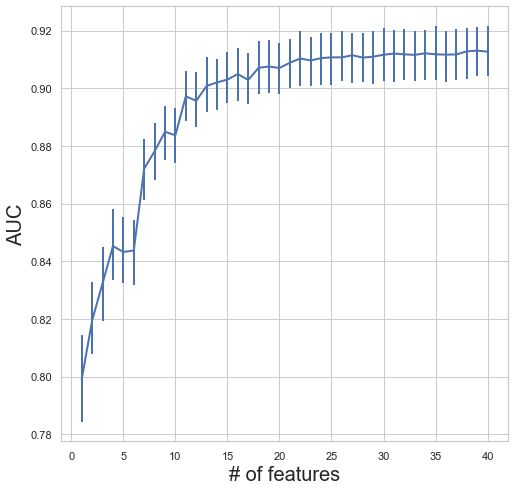

In [61]:
import seaborn as sns
sns.set(style="whitegrid")


x = list(range(1,41))

fig,ax = plt.subplots(figsize=(8,8))
plt.errorbar(x,m, yerr = np.vstack((np.array(m)-np.array(l),np.array(h)-np.array(m))), alpha=1, linewidth=2)
#plt.plot(x,auc_vals, 'r-o', ms=5)
plt.xlabel('# of features', fontsize=20)
plt.ylabel('AUC', fontsize=20)
#plt.savefig('auc_v_features_lr_2yr_new.pdf')
plt.show()

### SVM 

In [62]:
%%time

auc, l, m, h =  auc_feat(sv_models, np.mean(sv_feat, axis=0), data, outcome)

1 features
2 features
3 features
4 features
5 features
6 features
7 features
8 features
9 features
10 features
11 features
12 features
13 features
14 features
15 features
16 features
17 features
18 features
19 features
20 features
21 features
22 features
23 features
24 features
25 features
26 features
27 features
28 features
29 features
30 features
31 features
32 features
33 features
34 features
35 features
36 features
37 features
38 features
39 features
40 features
CPU times: user 31min 1s, sys: 1.46 s, total: 31min 3s
Wall time: 31min 2s


In [63]:
np.save('sv_auc_low_hi_med.npy',[auc, l, m, h])

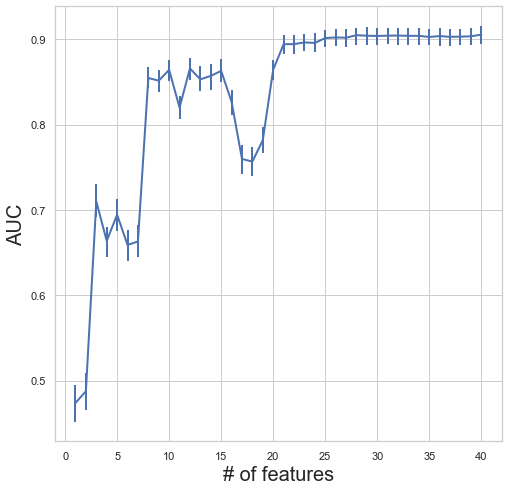

In [64]:
import seaborn as sns
sns.set(style="whitegrid")


x = list(range(1,41))

fig,ax = plt.subplots(figsize=(8,8))
plt.errorbar(x,m, yerr = np.vstack((np.array(m)-np.array(l),np.array(h)-np.array(m))), alpha=1, linewidth=2)
#plt.plot(x,auc_vals, 'r-o', ms=5)
plt.xlabel('# of features', fontsize=20)
plt.ylabel('AUC', fontsize=20)
#plt.savefig('auc_v_features_sv_2yr_new.pdf')
plt.show()

### XGB

In [66]:
%%time

auc, l, m, h =  auc_feat(xg_models, np.mean(xg_feat, axis=0), data, outcome)

1 features
2 features
3 features
4 features
5 features
6 features
7 features
8 features
9 features
10 features
11 features
12 features
13 features
14 features
15 features
16 features
17 features
18 features
19 features
20 features
21 features
22 features
23 features
24 features
25 features
26 features
27 features
28 features
29 features
30 features
31 features
32 features
33 features
34 features
35 features
36 features
37 features
38 features
39 features
40 features
CPU times: user 19min 59s, sys: 0 ns, total: 19min 59s
Wall time: 19min 58s


In [67]:
np.save('xgb_auc_low_hi_med.npy',[auc, l, m, h])

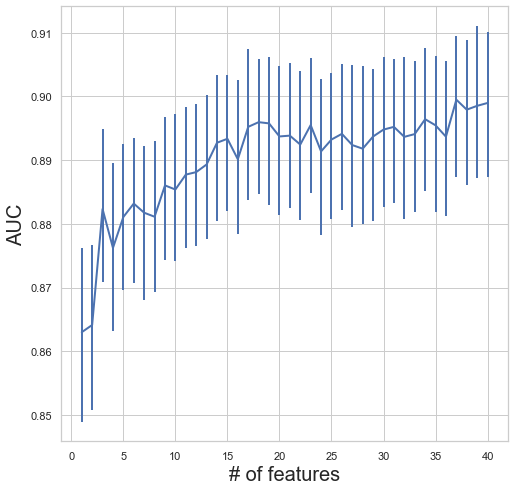

In [68]:
import seaborn as sns
sns.set(style="whitegrid")


x = list(range(1,41))

fig,ax = plt.subplots(figsize=(8,8))
plt.errorbar(x,m, yerr = np.vstack((np.array(m)-np.array(l),np.array(h)-np.array(m))), alpha=1, linewidth=2)
#plt.plot(x,auc_vals, 'r-o', ms=5)
plt.xlabel('# of features', fontsize=20)
plt.ylabel('AUC', fontsize=20)
#plt.savefig('auc_v_features_sv_2yr_new.pdf')
plt.show()

In [74]:
np.save('encoded_variables.npy', variables)

## Run models only with top variables 

In [130]:
top_vars = ['MEMORY', 'TRAILB', 'DECCLIN', 'ORIENT', 'HOMEHOBB', 'INDEPEND']

In [131]:
with open('processed_data.pkl', 'rb') as f:
    [data, variables, outcome] = pickle.load(f)

In [132]:
df = pd.DataFrame(data, columns=variables)

In [133]:
df.head()

,NACCREAS,NACCREFR,BIRTH_#MOS,SEX,HISPANIC,HISPOR,PRIMLANG,EDUC,NACCLIVS,INDEPEND,...,MEMUNITS_PROB,MEMTIME,BOSTON,BOSTON_PROB,COGSTAT,NACCC1,RANDVAR_0,RANDVAR_1,RANDVAR_2,RANDVAR_3
0,1.0,8.0,746.0,2.0,0.0,2.0,1.0,16.0,2.0,1.0,...,97.0,32.0,27.0,97.0,3.0,0.0,-0.583757,2.5,2.0,997.0
1,1.0,2.0,721.0,1.0,0.0,3.0,1.0,18.0,2.0,2.0,...,97.0,19.0,29.0,97.0,0.0,0.0,1.838755,0.0,1.0,997.0
2,1.0,8.0,1055.0,2.0,0.0,3.0,1.0,18.0,1.0,1.0,...,97.0,15.0,29.0,97.0,3.0,0.0,1.655697,0.5,1.0,997.0
3,1.0,8.0,929.0,1.0,1.0,1.0,2.0,0.0,3.0,1.0,...,97.0,17.0,14.0,97.0,3.0,0.0,5.348681,0.0,2.0,997.0
4,1.0,8.0,975.0,2.0,0.0,3.0,1.0,15.0,2.0,1.0,...,96.0,15.0,22.0,97.0,4.0,0.0,-1.547942,1.0,1.0,997.0


In [134]:
data = df[top_vars]

In [135]:
data.head()

,MEMORY,TRAILB,DECCLIN,ORIENT,HOMEHOBB,INDEPEND
0,0.5,76.0,1.0,0.0,0.0,1.0
1,0.0,105.0,1.0,0.0,0.0,2.0
2,0.5,80.0,1.0,0.0,0.0,1.0
3,0.0,144.0,0.0,0.0,0.0,1.0
4,0.5,108.0,1.0,0.0,0.0,1.0


In [136]:
var_types_top = [var_types_old[np.where(variables_old==v)[0][0]] for v in data.columns.values]

In [137]:
variables = data.columns.values

In [138]:
%%time

from sklearn import preprocessing
enc = preprocessing.OneHotEncoder()

#data = np.vstack((train_data, test_data))

data = data.values

count=0

for i,type_ in enumerate(var_types_top):
    
    if type_=='Categorical':
        
        print(variables[i-count])
        
        X = data[:,i-count].reshape(-1, 1)
        enc.fit(X)
        X_new = enc.transform(X).toarray()
        #print(X_new)
        
        data = np.delete(data, i-count, 1)
        data = np.hstack((data, X_new))
        
        new_vars = add_new_variable(variables[i-count], len(X_new[0]))
        
        variables = np.delete(variables, i-count)
        variables = np.concatenate((variables, new_vars))
        
        count+=1
        
data = preprocessing.scale(data)

CPU times: user 9.76 ms, sys: 1.91 ms, total: 11.7 ms
Wall time: 9.84 ms


#### RF 

In [139]:
%%time

params = {'n_estimators':[50,100,200],
             'criterion': ('gini', 'entropy'),
             'min_samples_split': [2,10,20],
             'max_depth': [10,50],
             'max_features': (5, 12)
             }

model = rf()

rf_auc, rf_metrics, rf_models, rf_err, rf_feat, rf_probs, rf_preds = run_k_fold(model,'RF',params,data,outcome)

RF
RF
RF
RF
RF
CPU times: user 57.9 s, sys: 2.36 s, total: 1min
Wall time: 1min 37s


In [140]:
np.mean(rf_metrics, axis=0)

array([ 0.90128679,  0.25382064,  0.97518007, 10.32418212,  0.76515453,
        0.02481993,  0.74617936,  0.53917307,  0.91969386,  0.04827913])

In [141]:
with open ('5fold/rf_results_top.pkl', 'wb') as f:
    
    pickle.dump([rf_auc, rf_metrics, rf_models, rf_err, rf_feat, rf_probs, rf_preds, variables], f)

#### LR

In [142]:
lr_params={'C':[0.1,1,5,10],
          'max_iter':[10000]}


model = lr()

lr_auc, lr_metrics, lr_models, lr_err, lr_feat, lr_probs, lr_preds = run_k_fold(model,'LR',lr_params,data,outcome)

LR
LR
LR
LR
LR


In [143]:
with open ('5fold/lr_results_top.pkl', 'wb') as f:
    
    pickle.dump([lr_auc, lr_metrics, lr_models, lr_err, lr_feat, lr_probs, lr_preds, variables], f)

#### SVM

In [144]:
%%time

svm_params={'C':[0.1,1,10]}

model = sv(probability=True, kernel = 'linear')

sv_auc, sv_metrics, sv_models, sv_err, sv_feat, sv_probs, sv_preds = run_k_fold(model,'SVM',svm_params,data,outcome)

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

SVM


/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

SVM


/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

SVM


/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

SVM


/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

SVM
CPU times: user 1min 10s, sys: 16.2 s, total: 1min 26s
Wall time: 2min 49s


/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: 

In [146]:
with open ('5fold/svm_results_top.pkl', 'wb') as f:
    
    pickle.dump([sv_auc, sv_metrics, sv_models, sv_err, sv_feat, sv_probs, sv_preds, variables], f)

#### XGB

In [147]:
%%time 

params = {'n_estimators':[50,100,200],
             'criterion': ('friedman_mse', 'mse', 'mae'),
             'min_samples_split': [2,5,10,20],
             'max_depth': [5,10,50],
             'max_features': ('sqrt', 'log2', 12, 5)
             }

model = GradientBoostingClassifier(random_state=0)

xg_auc, xg_metrics, xg_models, xg_err, xg_feat, xg_probs, xg_preds = run_k_fold(model,'XGB',params,data,outcome)

XGB


/home/links/crj207/.conda/envs/nacc/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


XGB
XGB
XGB
XGB
CPU times: user 5min 21s, sys: 12.6 s, total: 5min 33s
Wall time: 3h 49min 30s


In [148]:
with open ('5fold/xgb_results_top.pkl', 'wb') as f:
    
    pickle.dump([xg_auc, xg_metrics, xg_models, xg_err, xg_feat, xg_probs, xg_preds, variables], f)

## ----------------------------------------------------------------------------- 

## Train models without reverters in test set 

In [101]:
with open('processed_data.pkl', 'rb') as f:
    [data, variables, outcome] = pickle.load(f)

In [102]:
df = pd.DataFrame(data, columns=variables)

In [103]:
df.head()

,NACCREAS,NACCREFR,BIRTH_#MOS,SEX,HISPANIC,HISPOR,PRIMLANG,EDUC,NACCLIVS,INDEPEND,...,MEMUNITS_PROB,MEMTIME,BOSTON,BOSTON_PROB,COGSTAT,NACCC1,RANDVAR_0,RANDVAR_1,RANDVAR_2,RANDVAR_3
0,1.0,8.0,746.0,2.0,0.0,2.0,1.0,16.0,2.0,1.0,...,97.0,32.0,27.0,97.0,3.0,0.0,-0.583757,2.5,2.0,997.0
1,1.0,2.0,721.0,1.0,0.0,3.0,1.0,18.0,2.0,2.0,...,97.0,19.0,29.0,97.0,0.0,0.0,1.838755,0.0,1.0,997.0
2,1.0,8.0,1055.0,2.0,0.0,3.0,1.0,18.0,1.0,1.0,...,97.0,15.0,29.0,97.0,3.0,0.0,1.655697,0.5,1.0,997.0
3,1.0,8.0,929.0,1.0,1.0,1.0,2.0,0.0,3.0,1.0,...,97.0,17.0,14.0,97.0,3.0,0.0,5.348681,0.0,2.0,997.0
4,1.0,8.0,975.0,2.0,0.0,3.0,1.0,15.0,2.0,1.0,...,96.0,15.0,22.0,97.0,4.0,0.0,-1.547942,1.0,1.0,997.0


In [104]:
%%time

from sklearn import preprocessing
enc = preprocessing.OneHotEncoder()

#data = np.vstack((train_data, test_data))

count=0

data=df.values

for i,type_ in enumerate(var_types):
    
    if type_=='Categorical':
        
        print(variables[i-count])
        
        X = data[:,i-count].reshape(-1, 1)
        enc.fit(X)
        X_new = enc.transform(X).toarray()
        #print(X_new)
        
        data = np.delete(data, i-count, 1)
        data = np.hstack((data, X_new))
        
        new_vars = add_new_variable(variables[i-count], len(X_new[0]))
        
        variables = np.delete(variables, i-count)
        variables = np.concatenate((variables, new_vars))
        
        count+=1
        
data = preprocessing.scale(data)

NACCREAS
NACCREFR
HISPOR
PRIMLANG
NACCLIVS
RESIDENC
MARISTAT
HANDED
NACCNIHR
INRELTO
CVHATT
CVAFIB
CVANGIO
CVBYPASS
CVPACE
CVCHF
CVOTHR
CBSTROKE
CBTIA
SEIZURES
TRAUMBRF
TRAUMEXT
TRAUMCHR
NCOTHR
HYPERTEN
HYPERCHO
DIABETES
B12DEF
THYROID
INCONTU
INCONTF
ALCOHOL
ABUSOTHR
PSYCDIS
NPIQINF
NACCCOGF
COGMODE
NACCBEHF
BEMODE
NACCMOTF
MOMODE
COURSE
FRSTCHG
MMSELOC
MMSELAN
MMSEORDA_PROB
MMSEORLO_PROB
NACCMMSE_PROB
NPSYCLOC
NPSYLAN
LOGIMEM_PROB
DIGIF_PROB
DIGIFLEN_PROB
DIGIB_PROB
DIGIBLEN_PROB
ANIMALS_PROB
VEG_PROB
TRAILA_PROB
TRAILB_PROB
WAIS_PROB
MEMUNITS_PROB
BOSTON_PROB
COGSTAT
RANDVAR_3
CPU times: user 2 s, sys: 1.02 s, total: 3.02 s
Wall time: 2.99 s


In [105]:
df = pd.DataFrame(data, columns=variables)

In [106]:
misdiagnosed = np.load('misdiagnosed.npy')

In [107]:
df['MISS'] = misdiagnosed

In [108]:
df.columns[-1]

'MISS'

In [114]:
def run_k_fold_miss(models,data,outcome):

    sk = skf(n_splits=5)

    auc, metrics, err, probs, preds = [],[],[],[],[]

    outcome = np.array(outcome, dtype=int)
    
    count=0

    for train, test in sk.split(data, outcome):

        clf = models[count]
        
        data_train = np.array([r for r in data[train] if r[-1]!=1])

        clf.fit(data_train[:,:-1], outcome[train])

        pred = clf.predict(data[test][:,:-1])
        prob = clf.predict_proba(data[test][:,:-1])[:,1]

        auc.append(roc_auc_score(outcome[test], prob))

        ap = np.array(list(zip(outcome[test],pred)))

        _, performance = calculate_diagnostic_performance(ap)

        metrics.append(performance)

        errors = bootstrap_metrics(outcome[test], pred, prob,1000)

        err.append(errors)
        
        probs.extend(prob)
        
        preds.extend(pred)
        
        count+=1
            
    return auc, metrics, err, probs, preds 

#### RF 

In [115]:
%%time

with open ('5fold/rf_results.pkl', 'rb') as f:
    _, _, rf_models, _, _, _, _, _ = pickle.load(f)

rf_auc, rf_metrics, rf_err, rf_probs, rf_preds = run_k_fold_miss(rf_models,data,outcome)

CPU times: user 1min 59s, sys: 192 ms, total: 1min 59s
Wall time: 1min 59s


In [116]:
np.mean(rf_metrics, axis=0)

array([9.17423023e-01, 3.29081622e-01, 9.84569299e-01, 2.25241278e+01,
       6.81435632e-01, 1.54307014e-02, 6.70918378e-01, 7.12055415e-01,
       9.27842840e-01, 4.75604788e-02])

In [117]:
with open ('5fold/rf_results_miss.pkl', 'wb') as f:
    
    pickle.dump([rf_auc, rf_metrics, rf_err, rf_probs, rf_preds], f)

#### LR

In [118]:
with open ('5fold/lr_results.pkl', 'rb') as f:
    _, _, lr_models, _, _, _, _, _ = pickle.load(f)

lr_auc, lr_metrics, lr_err, lr_probs, lr_preds = run_k_fold_miss(lr_models,data,outcome)

In [123]:
with open ('5fold/lr_results_miss.pkl', 'wb') as f:
    
    pickle.dump([lr_auc, lr_metrics, lr_err, lr_probs, lr_preds], f)

#### SVM

In [125]:
%%time

with open ('5fold/svm_results.pkl', 'rb') as f:
    _, _, sv_models, _, _, _, _, _ = pickle.load(f)

sv_auc, sv_metrics, sv_err, sv_probs, sv_preds = run_k_fold_miss(sv_models,data,outcome)

CPU times: user 26min 49s, sys: 1.71 s, total: 26min 50s
Wall time: 26min 50s


In [126]:
sv_auc

[0.9153275340954394,
 0.914360414986232,
 0.9106431165738893,
 0.9013235300956607,
 0.9087035306611266]

In [127]:
with open ('5fold/svm_results_miss.pkl', 'wb') as f:
    
    pickle.dump([sv_auc, sv_metrics,sv_err, sv_probs, sv_preds], f)

#### XGB

In [128]:
%%time 

with open ('5fold/xgb_results.pkl', 'rb') as f:
    _, _, xg_models, _, _, _, _, _ = pickle.load(f)

xg_auc, xg_metrics, xg_err,xg_probs, xg_preds = run_k_fold_miss(xg_models,data,outcome)

CPU times: user 1min 3s, sys: 104 ms, total: 1min 3s
Wall time: 1min 3s


In [129]:
with open ('5fold/xgb_results_miss.pkl', 'wb') as f:
    
    pickle.dump([xg_auc, xg_metrics, xg_err,xg_probs, xg_preds], f)